In [41]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time # 用于计时

In [42]:
# --- 配置 ---
file_path = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv'
# 选择用于训练的特征列
# review_content 是文本特征
# rating 和 game_name 是类别特征 (rating也可以视为数值，但作为类别通常效果不错)
# likes 是数值特征
feature_columns = ['review_content', 'likes', 'game_name']
text_feature_columns = ['review_content']
categorical_feature_columns = ['game_name']
target_column = 'sentiment'
test_size = 0.2 # 20% 的数据作为测试集
random_state = 42 # 为了结果可复现

In [43]:
# --- 1. 加载数据 ---
print(f"开始加载数据: {file_path}")
try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，总行数: {len(df)}")
    # 查看数据基本信息和目标变量分布
    print("\n数据前5行:")
    print(df.head())
    print("\n数据信息:")
    df.info()
    print(f"\n目标变量 '{target_column}' 分布:")
    print(df[target_column].value_counts(normalize=True))

    # 简单处理缺失值 (例如，填充文本和类别特征，删除数值特征缺失行)
    # 注意：CatBoost 内部可以处理缺失值，但显式处理有时更好控制
    df['review_content'] = df['review_content'].fillna('') # 文本填充空字符串
    df['game_name'] = df['game_name'].fillna('Unknown') # 类别填充特定值
    df['rating'] = df['rating'].fillna(df['rating'].mode()[0]) # 类别用众数填充
    df.dropna(subset=['likes', target_column], inplace=True) # 删除数值或目标列的缺失值行
    print(f"\n处理缺失值后，剩余行数: {len(df)}")

    # 确保目标列是整数类型
    df[target_column] = df[target_column].astype(int)

except FileNotFoundError:
    print(f"错误: 文件未找到 {file_path}")
    exit()
except Exception as e:
    print(f"加载或预处理数据时发生错误: {e}")
    exit()

开始加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv
数据加载成功，总行数: 39985

数据前5行:
     user_id       username  rating                 review_content  likes  \
0  696432312            。。。       5            可以体验一下，剧情不错，但可能会有点迷      0   
1  679295528           云淡风轻       5                           剧情很好      0   
2  700357357        qqqqq美女       5  刺激，感受到了友情，亲情，自我，爱慕，传承，等待 ，与纯真      1   
3  402380140  User402380140       5            毋庸置疑的神作 第一次回溯时间的是葵啊      2   
4  434114561           不忆往事       5                   没有别的可以说，剧情神作      1   

          publish_time       device_model         game_name  sentiment  
0  2025-04-05 20:13:00        OPPO K7x中国版  7_years_from_now          1  
1  2025-04-05 17:35:00   Honor Play 40 5G  7_years_from_now          1  
2  2025-04-04 22:59:00        OPPO PGGM10  7_years_from_now          1  
3  2025-04-03 09:48:00  Redmi Note 10 Pro  7_years_from_now          1  
4  2025-04-03 01:08:00        Vivo V2148A  7_ye

In [44]:
# --- 2. 准备特征和目标变量 ---
X = df[feature_columns]
y = df[target_column]

# --- 3. 划分训练集和测试集 ---
print(f"\n划分数据集，测试集比例: {test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y # 保持训练集和测试集中类别比例一致
)
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


划分数据集，测试集比例: 0.2
训练集大小: 31988, 测试集大小: 7997


In [45]:
# --- 4. 初始化 CatBoost 分类器 ---
print("\n初始化 CatBoostClassifier...")
# 确定损失函数（根据目标变量的类别数量）
num_classes = len(y.unique())
if num_classes == 2:
    loss_function = 'Logloss'
    eval_metric = 'Accuracy' # 或者 'AUC', 'F1'
    print("检测到二分类任务，使用 'Logloss'")
elif num_classes > 2:
    loss_function = 'MultiClass'
    eval_metric = 'Accuracy' # 或者 'TotalF1'
    print(f"检测到 {num_classes} 分类任务，使用 'MultiClass'")
else:
    print("错误：目标变量类别数少于2，无法进行分类。")
    exit()

model = CatBoostClassifier(
    iterations=1000,          # 迭代次数（树的数量）
    learning_rate=0.1,       # 学习率
    depth=8,                 # 树的深度
    loss_function=loss_function, # 损失函数
    eval_metric=eval_metric,     # 评估指标
    task_type="GPU",         # 使用 GPU
    devices='0',             # 指定 GPU 设备 ID (通常是 '0')
    random_seed=random_state,  # 随机种子
    verbose=10,             # 每 10 次迭代输出一次信息
    early_stopping_rounds=50, # 如果验证集指标在 50 轮内没有提升，则停止训练
    text_features=text_feature_columns,         # 指定文本特征列名
    cat_features=categorical_feature_columns    # 指定类别特征列名
    # CatBoost 会自动处理类别特征和文本特征，无需手动编码
)


初始化 CatBoostClassifier...
检测到二分类任务，使用 'Logloss'


In [46]:
# --- 5. 训练模型 ---
print("\n开始训练模型...")
start_time = time.time()
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test), # 使用测试集进行早停和性能监控
    # text_features 和 cat_features 在初始化时已指定
    # plot=True # 如果你想在训练过程中看到图表（可能需要额外库或在Jupyter环境）
)
end_time = time.time()
print(f"模型训练完成，耗时: {end_time - start_time:.2f} 秒")


开始训练模型...
0:	learn: 0.7499687	test: 0.7405277	best: 0.7405277 (0)	total: 84.6ms	remaining: 1m 24s
10:	learn: 0.7739465	test: 0.7635363	best: 0.7635363 (9)	total: 928ms	remaining: 1m 23s
20:	learn: 0.7731649	test: 0.7636614	best: 0.7637864 (14)	total: 1.74s	remaining: 1m 21s
30:	learn: 0.7765099	test: 0.7641616	best: 0.7655371 (26)	total: 2.58s	remaining: 1m 20s
40:	learn: 0.7780418	test: 0.7642866	best: 0.7655371 (26)	total: 3.41s	remaining: 1m 19s
50:	learn: 0.7796049	test: 0.7651619	best: 0.7655371 (26)	total: 4.26s	remaining: 1m 19s
60:	learn: 0.7795423	test: 0.7650369	best: 0.7655371 (26)	total: 5.01s	remaining: 1m 17s
70:	learn: 0.7803864	test: 0.7657872	best: 0.7657872 (65)	total: 5.73s	remaining: 1m 15s
80:	learn: 0.7810429	test: 0.7654120	best: 0.7657872 (65)	total: 6.51s	remaining: 1m 13s
90:	learn: 0.7811992	test: 0.7657872	best: 0.7657872 (65)	total: 7.23s	remaining: 1m 12s
100:	learn: 0.7817932	test: 0.7659122	best: 0.7660373 (95)	total: 8.05s	remaining: 1m 11s
110:	learn:

In [47]:
# --- 6. 进行预测 ---
print("\n在测试集上进行预测...")
y_pred = model.predict(X_test)
# CatBoost predict 默认返回概率最高的类别，如果是二分类且需要概率，用 predict_proba


在测试集上进行预测...



模型评估:
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      2726
           1       0.79      0.87      0.83      5271

    accuracy                           0.77      7997
   macro avg       0.74      0.72      0.73      7997
weighted avg       0.76      0.77      0.76      7997


Confusion Matrix:
[[1528 1198]
 [ 670 4601]]


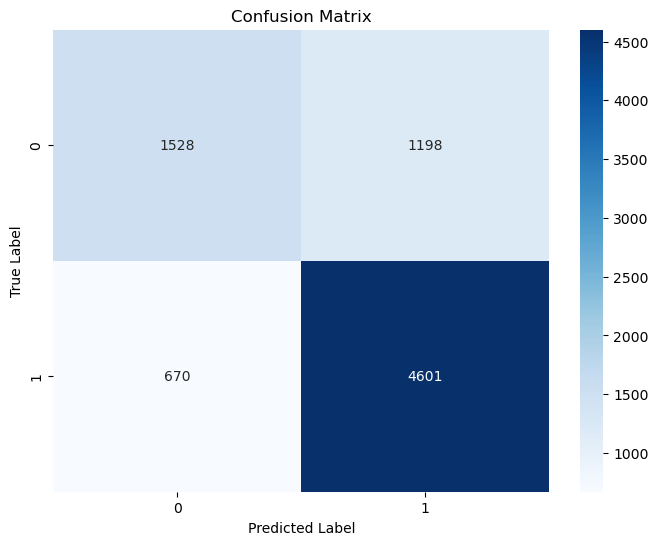


脚本执行完毕。


In [48]:
# --- 7. 评估模型 ---
print("\n模型评估:")

# Classification Report
print("Classification Report:")
try:
    # 获取目标类别的名称 (如果 y 是数字 0, 1, ...)
    target_names = [str(c) for c in sorted(y.unique())]
    print(classification_report(y_test, y_pred, target_names=target_names))
except Exception as e:
    print(f"生成 classification report 时出错: {e}")
    print("Classification Report (无 target_names):")
    print(classification_report(y_test, y_pred))


# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 可视化 Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n脚本执行完毕。")